In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding,Flatten,Dropout, Dense, Concatenate, TimeDistributed, Bidirectional,Attention
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from statistics import mode
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import functools
from scipy.stats import norm

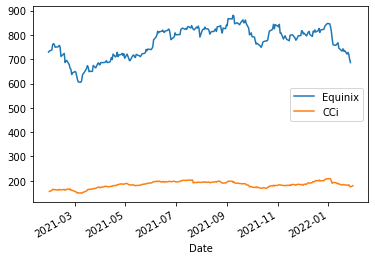

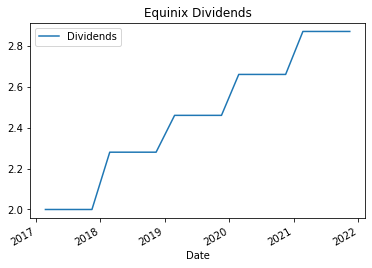

In [63]:
eqix_df=pd.read_csv('EQIX.csv',parse_dates=['Date'],index_col=0)
eqix_df=eqix_df.sort_index().tail(254)
cci_df = pd.read_csv('CCI.csv',parse_dates=['Date'],index_col=0)
cci_df=cci_df.sort_index().tail(254)
eqix_df['Open'].plot(label='Equinix')
cci_df['Open'].plot(label='CCi')
plt.legend()
plt.show()
eqix_dividend=pd.read_csv('EQIX_Dividend.csv',parse_dates=['Date'],index_col=0)
eqix_dividend.plot()
plt.title('Equinix Dividends')
plt.show()

C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8456/1052066201.py:8: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='volatility'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=[line1])
C:\Users\DNISHI~1\AppData\Local\Temp/ipykernel_8456/1052066201.py:14: UserWarning: Legend does not support <AxesSubplot:xlabel='Date', ylabel='pct_change'> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  twinx.legend(handles=[line2])


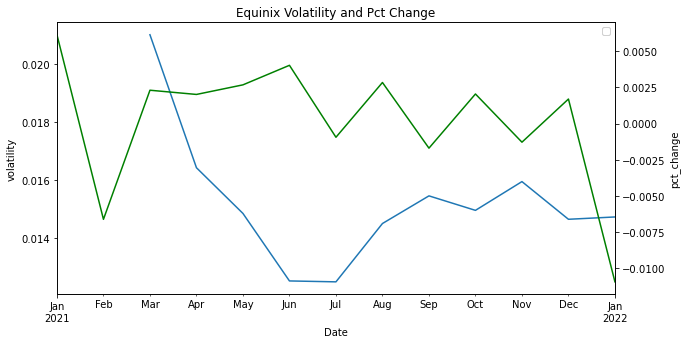

In [64]:
fig,ax=plt.subplots(figsize=(10,5))
eqix_returns=eqix_df.pct_change()
rolling=eqix_returns['Open'].rolling(30)
volatility = rolling.std().dropna()
vol_mean= volatility.resample("M").mean()
line1=vol_mean.plot(label="volatility",ax=ax)
ax.set_ylabel("volatility")
ax.legend(handles=[line1])
twinx=ax.twinx()
volility_chg=eqix_df.pct_change().resample("M").mean()

line2=volility_chg['Open'].plot(label="pct change",ax=twinx,c='g')
twinx.set_ylabel('pct_change')
twinx.legend(handles=[line2])
plt.title('Equinix Volatility and Pct Change')
plt.show()

                eqix       cci
Date                          
2021-01-29  0.006132  0.024787
2021-02-01  0.006122  0.024787
2021-02-02  0.029988  0.031750
2021-02-03  0.005276 -0.003150
2021-02-04 -0.005340 -0.011728
...              ...       ...
2022-01-24 -0.020065 -0.008743
2022-01-25  0.010127  0.001268
2022-01-26 -0.011069  0.009195
2022-01-27 -0.027302 -0.031642
2022-01-28 -0.020573 -0.013972

[253 rows x 2 columns]
VaR_95:  0.023104117456808126 ; Backtest:  1.0


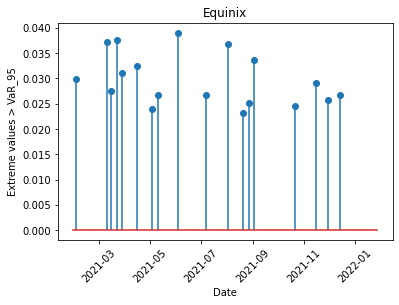

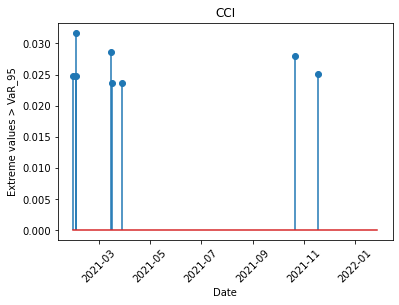

95% confidence the maximum daily loss will be 203540.2294256147


In [94]:
#https://www.interviewqs.com/blog/value-at-risk
initial_investment=10000000

weights = np.array([.50, .5])

eqix_df['Pct_Change'] =eqix_df['Open'].pct_change()
cci_df['Pct_Change']=cci_df['Open'].pct_change()

dfs=[eqix_df['Pct_Change'],cci_df['Pct_Change']]
returns = functools.reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
returns=returns.rename(columns={"Pct_Change_x":"eqix","Pct_Change_y":"cci"}).bfill()

print(returns)

cov_matrix = returns.cov()
avg_returns = returns.mean()

portfolio_mean = avg_returns.dot(weights)
 
# Calculate portfolio standard deviation
portfolio_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
# Calculate mean of investment
mean_investment = (1+portfolio_mean) * initial_investment
             
# Calculate standard deviation of investmnet
stdev_investment = initial_investment * portfolio_stdev

#cov_matrix=returns.cov()
#avg_returns=returns.mean()

VaR_95 = np.quantile(returns, 0.95)

extreme_values = returns[returns > VaR_95]
print("VaR_95: ", VaR_95, "; Backtest: ", len(extreme_values) / len(returns) )

plt.stem(extreme_values.index, extreme_values['eqix'].values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title('Equinix')
plt.show()

plt.stem(extreme_values.index, extreme_values['cci'].values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title('CCI')
plt.show()

conf_level1 = 0.05
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)

var_1d1 = initial_investment - cutoff1

print("95% confidence the maximum daily loss will be", var_1d1)


In [3]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

COLUMNS=['Open']
dataset=eqix_df[COLUMNS]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

look_back=10
trainX=[]
testX=[]
y_train=[]

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
latent_dim=1000
n_future=1

model = Sequential()

model.add(Bidirectional(LSTM(units=latent_dim, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))
#LSTM 1
model.add(Bidirectional(LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name='lstm1'))) 
#model.add(LSTM(latent_dim,return_sequences=True,dropout=0.4,recurrent_dropout=0.4,name='lstm1')) 

#LSTM 2 
model.add(Bidirectional(LSTM(latent_dim,return_sequences=True,dropout=0.2,recurrent_dropout=0.4,name='lstm2')))
#model.add(LSTM(latent_dim,return_sequences=True,dropout=0.2,recurrent_dropout=0.4,name='lstm2'))

#LSTM 3 
model.add(Bidirectional(LSTM(latent_dim, return_sequences=False,dropout=0.2,recurrent_dropout=0.4,name='lstm3')))
#model.add(LSTM(latent_dim, return_sequences=False,dropout=0.2,recurrent_dropout=0.4,name='lstm3'))

model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

#input_shape=(X_train.shape[1], 1)
#model.build(input_shape)
#model.summary()

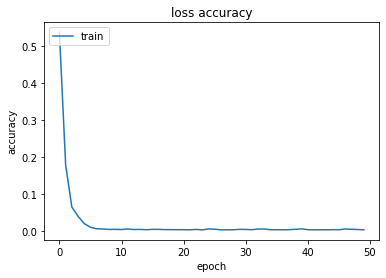

In [24]:
history=model.fit(X_train, y_train,epochs=50,verbose=0)

plt.plot(history.history['loss'])
plt.title('loss accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

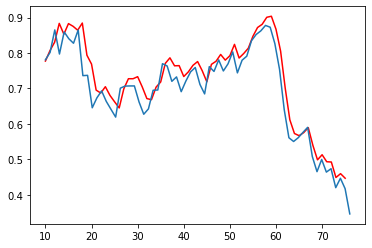

In [25]:
#print(X_test)
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='red')
#plt.plot(testPredictPlot)
#plt.legend(['Actual','Train','Test'])
x=np.linspace(look_back,len(prediction)+look_back,len(y_test))
plt.plot(x,y_test)
plt.show()